In [1]:
import requests

In [8]:
resp = requests.get('https://api.hh.ru/vacancies/1')

In [16]:
url1 = 'https://api.hh.ru/vacancies?specialization=1.221'

In [17]:
url2 = 'https://api.hh.ru/vacancies?specialization=13.228'

In [19]:
searches = []
for page in range(20):
    searches.append(
        requests.get(url1 + '&page={}&per_page=100'.format(page)).json()
    )

In [20]:
len(searches)

20

In [22]:
for page in range(20):
    searches.append(
        requests.get(url2 + '&page={}&per_page=100'.format(page)).json()
    )

In [26]:
searches[0]['items'][0]['url']

'https://api.hh.ru/vacancies/22497307?host=hh.ru'

In [27]:
vacs = [x['items'] for x in searches]

In [33]:
vacs = sum(vacs, [])

In [35]:
urls = [x['url'] for x in vacs]

In [39]:
from tqdm import tqdm

In [41]:
vac_dicts = []
for url in tqdm(urls):
    vac_dicts.append(requests.get(url).json())

100%|██████████| 4000/4000 [23:49<00:00,  2.80it/s]


In [47]:
import pickle
f = open('vac_dicts.pckl', 'w')
pickle.dumps(vac_dicts, 'vac_dicts.pckl')

TypeError: file must have a 'write' attribute

In [58]:
with open('data.pickle', 'wb') as f:
    pickle.dump(vac_dicts, f)

In [54]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [56]:
from bs4 import BeautifulSoup
texts = []
for v in tqdm(data):
    texts.append(
        BeautifulSoup(v['description']).text
    )

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.4/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/lib/python3.4/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
100%|██████████| 4000/4000 [00:10<00:00, 379.51it/s]


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
GROUPING_SPACE_REGEX = re.compile(r'([^\w]|[+])', re.UNICODE)
def simple_word_tokenize(text, _split=GROUPING_SPACE_REGEX.split):
    return [t for t in _split(text.lower()) if t and not t.isspace()]

In [92]:
import pymorphy2
m= pymorphy2.MorphAnalyzer()

In [144]:
def token_r(text):
    words = simple_word_tokenize(text)
    return [m.parse(x)[0].normal_form for x in words if len(x) >= 4]

In [146]:
cv = CountVectorizer(tokenizer=token_r, stop_words=stop_w)

In [147]:
# http://pymorphy2.readthedocs.io/en/latest/_modules/pymorphy2/tokenizers.html

In [148]:
matrix = cv.fit_transform(texts).toarray()

In [149]:
matrix.shape

(4000, 17724)

In [150]:
matrix[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [151]:
from sklearn.metrics.pairwise import cosine_similarity

In [152]:
cos_m = cosine_similarity(matrix)

In [153]:
cos_m.shape

(4000, 4000)

In [154]:
cos_m[0][1:]

array([ 0.26710481,  0.18631548,  0.18961227, ...,  0.04503139,
        0.04503139,  0.0934157 ])

In [155]:
%matplotlib inline

In [156]:
from matplotlib import pyplot as plt

In [157]:
import seaborn as sns

In [158]:
words = [y[0] for y in sorted(cv.vocabulary_.items(), key=lambda x: x[1])]

In [159]:
c_words = zip(words, sum(matrix))

In [139]:
c_words = sorted(c_words, key=lambda x: x[1], reverse=True)

In [143]:
stop_w = [x[0] for x in c_words[:25]]

In [162]:
cos_m[0][4:] + cos_m[1][4:] + cos_m[2][4:] + cos_m[3][4:] + cos_m[4][4:]

array([ 1.35519597,  0.01810862,  0.01781415, ...,  0.26532183,
        0.26532183,  0.51511947])

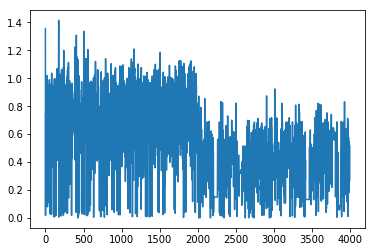

In [163]:
plt.plot(cos_m[0][4:] + cos_m[1][4:] + cos_m[2][4:] + cos_m[3][4:] + cos_m[4][4:])